In [14]:
!python -m spacy download es_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 46.4 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


In [15]:
import pandas as pd
import re
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [20]:
nlp = spacy.load("es_core_news_sm")

df = pd.read_csv("../datos/comentarios.csv")

if "texto_comentario" not in df.columns:
    raise ValueError("El archivo CSV debe tener una columna llamada 'comentario'.")

df = df.dropna(subset=["texto_comentario"])
print(f"Total de comentarios: {len(df)}")

def limpiar_y_lemmatizar(texto):
    texto = str(texto).lower()
    texto = re.sub(r"http\S+|www\S+|https\S+", "", texto)
    texto = re.sub(r"[^a-záéíóúñü\s]", "", texto)
    doc = nlp(texto)
    tokens = [
        token.lemma_ for token in doc
        if not token.is_stop
        and not token.is_punct
        and len(token.lemma_) > 2
    ]
    return " ".join(tokens)

print("Procesando textos con spaCy (esto puede tomar un momento)...")
df["procesado"] = df["texto_comentario"].apply(limpiar_y_lemmatizar)

vectorizer = CountVectorizer(
    max_df=0.95,
    min_df=2,
)
X = vectorizer.fit_transform(df["procesado"])

n_topics = 12
lda = LatentDirichletAllocation(
    n_components=n_topics,
    random_state=42,
    learning_method='batch'
)
lda.fit(X)

def mostrar_top_palabras(modelo, feature_names, n_top_words=10):
    topics = []
    for idx, topic in enumerate(modelo.components_):
        palabras = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics.append({"Tópico": idx, "Palabras clave": ", ".join(palabras)})
    return pd.DataFrame(topics)

feature_names = vectorizer.get_feature_names_out()
tabla_topics = mostrar_top_palabras(lda, feature_names)
print("\n=== Tópicos detectados ===")
print(tabla_topics)


Total de comentarios: 620
Procesando textos con spaCy (esto puede tomar un momento)...

=== Tópicos detectados ===
    Tópico                                     Palabras clave
0        0  video, cámara, calidad, excelente, ver, resist...
1        1  sonido, duro, batería, auricular, suela, cómod...
2        2  trama, personaje, puerto, historia, material, ...
3        3  laptop, rendimiento, teclado, gamer, pro, pant...
4        4  balón, agarre, durabilidad, diseño, rebote, ex...
5        5  olla, calidad, diseño, limpiar, fácil, comida,...
6        6  calidad, cámara, bajo, audio, micrófono, esper...
7        7  rápido, rendimiento, batería, pantalla, cámara...
8        8  pantalla, laptop, alto, resolución, rendimient...
9        9  material, camiseta, elegante, cómodo, diseño, ...
10      10  video, cámara, calidad, batería, estabilizació...
11      11  alto, rendimiento, pantalla, laptop, refresco,...


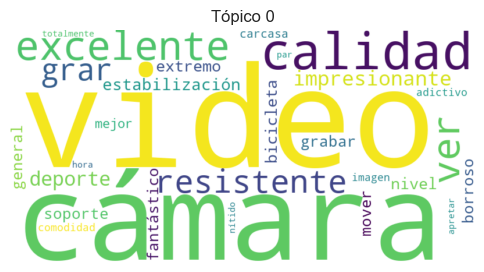

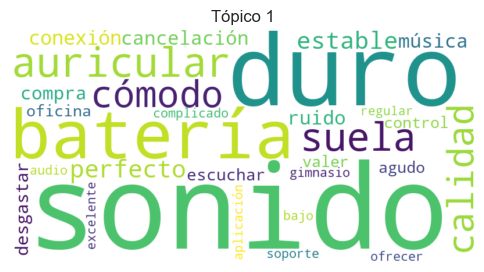

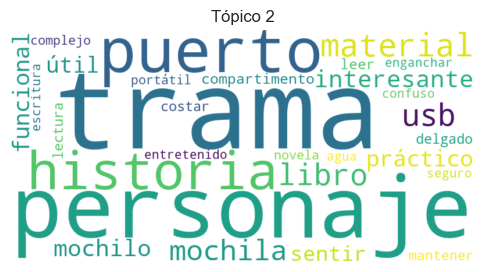

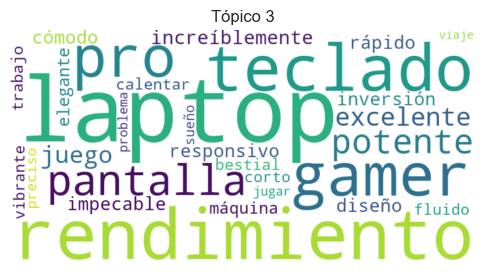

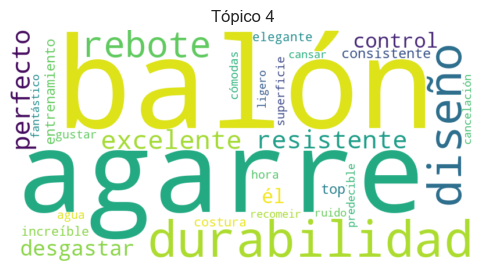

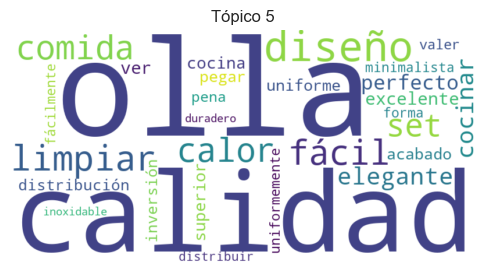

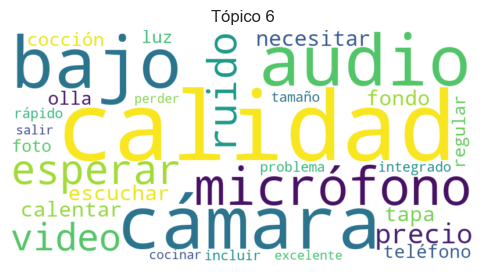

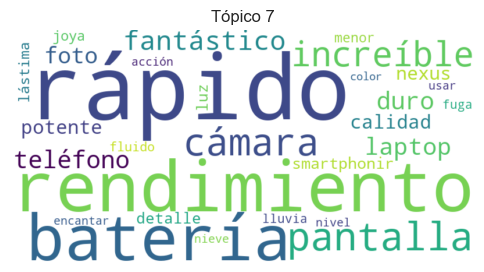

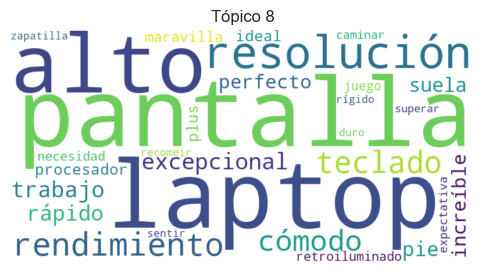

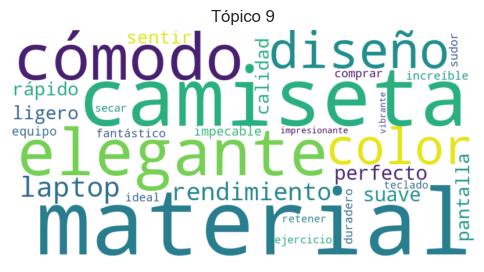

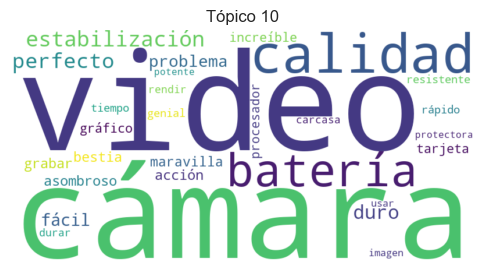

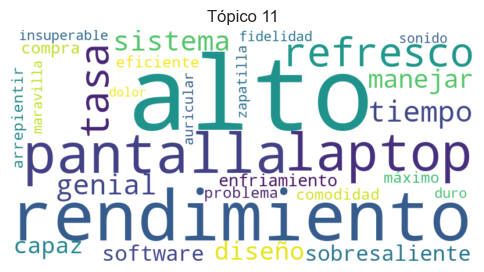

In [17]:
for i, topic in enumerate(lda.components_):
    plt.figure(figsize=(6, 4))
    word_freq = {feature_names[j]: topic[j] for j in topic.argsort()[:-30:-1]}
    wc = WordCloud(
        width=800,
        height=400,
        background_color="white"
    ).generate_from_frequencies(word_freq)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Tópico {i}")
    plt.show()

In [18]:
doc_topics = lda.transform(X)
df["Tópico Dominante"] = doc_topics.argmax(axis=1)

print("\n=== Distribución de tópicos ===")
print(df["Tópico Dominante"].value_counts())


=== Distribución de tópicos ===
Tópico Dominante
10    94
9     88
2     66
7     60
3     53
1     48
4     47
8     42
5     38
6     31
0     27
11    26
Name: count, dtype: int64
